# Analisi Comparativa tra Tecniche Lineari e Non Lineari di Riduzione Dimensionale per il Riconoscimento e la Verifica Facciale

**Roberto Carriero** - Ingegneria Informatica  
**Massimiliano Leone** - Ingegneria Elettronica  
Anno Accademico 2025 – 2026

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.manifold import TSNE
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Caricamento Dataset LFW

In [4]:
import os
from PIL import Image

dataset_path = os.path.expanduser("~/Downloads/archive-2/lfw-deepfunneled/lfw-deepfunneled")

min_faces_per_person = 70
image_size = (50, 37)

all_images = []
all_labels = []
all_names = []

for person_name in sorted(os.listdir(dataset_path)):
    person_folder = os.path.join(dataset_path, person_name)
    if os.path.isdir(person_folder):
        image_files = [f for f in os.listdir(person_folder) if f.endswith('.jpg')]
        if len(image_files) >= min_faces_per_person:
            for img_file in image_files:
                img_path = os.path.join(person_folder, img_file)
                img = Image.open(img_path).convert('L')
                img = img.resize((image_size[1], image_size[0]))
                all_images.append(np.array(img))
                all_labels.append(person_name)
            if person_name not in all_names:
                all_names.append(person_name)

images = np.array(all_images)
target_names = np.array(all_names)
name_to_idx = {name: idx for idx, name in enumerate(target_names)}
y = np.array([name_to_idx[name] for name in all_labels])
X = images.reshape(len(images), -1) / 255.0

n_samples, h, w = images.shape
n_features = X.shape[1]
n_classes = len(target_names)

print(f"Dataset: LFW (Labeled Faces in the Wild)")
print(f"Numero totale di campioni: {n_samples}")
print(f"Numero di classi (persone): {n_classes}")
print(f"Dimensione immagine: {h} x {w} = {n_features} pixel")
print(f"Nomi delle classi: {target_names}")

Dataset: LFW (Labeled Faces in the Wild)
Numero totale di campioni: 1288
Numero di classi (persone): 7
Dimensione immagine: 50 x 37 = 1850 pixel
Nomi delle classi: ['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Tony_Blair']


## 3. Esplorazione del Dataset e Statistiche Descrittive

In [5]:
print("STATISTICHE DESCRITTIVE DEL DATASET")
print(f"Shape delle immagini: {images.shape}")
print(f"Shape della matrice dati X: {X.shape}")
print(f"Shape del vettore target y: {y.shape}")
print(f"\nStatistiche dei valori pixel:")
print(f"  Min: {X.min():.4f}, Max: {X.max():.4f}, Media: {X.mean():.4f}, Std: {X.std():.4f}")

unique, counts = np.unique(y, return_counts=True)
class_distribution = pd.DataFrame({'Classe': [target_names[i] for i in unique], 'Numero Campioni': counts})
print(f"\nDistribuzione delle classi:")
print(class_distribution.to_string(index=False))
print(f"\nCampioni per classe - Min: {counts.min()}, Max: {counts.max()}, Media: {counts.mean():.1f}")

STATISTICHE DESCRITTIVE DEL DATASET
Shape delle immagini: (1288, 50, 37)
Shape della matrice dati X: (1288, 1850)
Shape del vettore target y: (1288,)

Statistiche dei valori pixel:
  Min: 0.0000, Max: 1.0000, Media: 0.3725, Std: 0.2704

Distribuzione delle classi:
           Classe  Numero Campioni
     Ariel_Sharon               77
     Colin_Powell              236
  Donald_Rumsfeld              121
    George_W_Bush              530
Gerhard_Schroeder              109
      Hugo_Chavez               71
       Tony_Blair              144

Campioni per classe - Min: 71, Max: 530, Media: 184.0


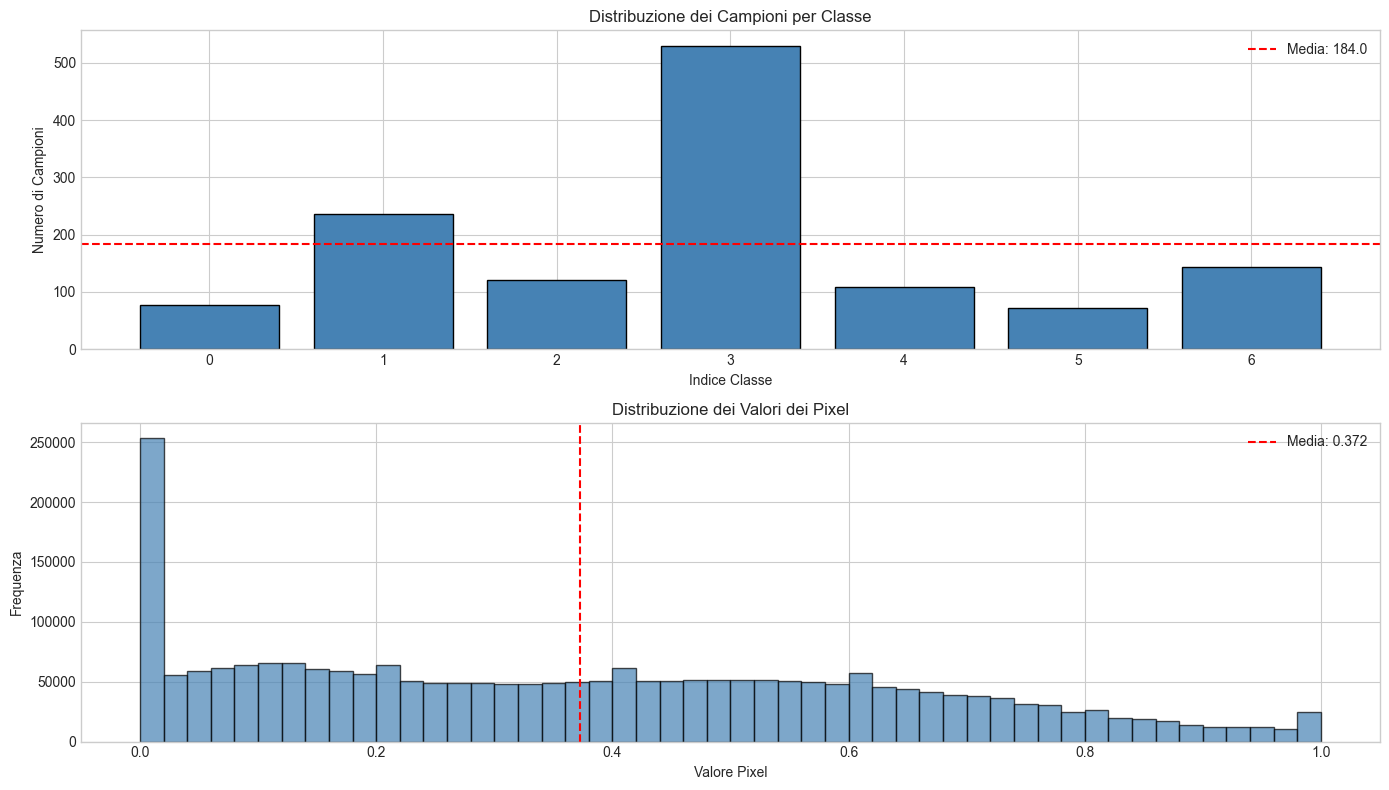

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].bar(range(len(counts)), counts, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Indice Classe')
axes[0].set_ylabel('Numero di Campioni')
axes[0].set_title('Distribuzione dei Campioni per Classe')
axes[0].axhline(y=counts.mean(), color='red', linestyle='--', label=f'Media: {counts.mean():.1f}')
axes[0].legend()

axes[1].hist(X.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Valore Pixel')
axes[1].set_ylabel('Frequenza')
axes[1].set_title('Distribuzione dei Valori dei Pixel')
axes[1].axvline(x=X.mean(), color='red', linestyle='--', label=f'Media: {X.mean():.3f}')
axes[1].legend()
plt.tight_layout()
plt.savefig('dataset_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

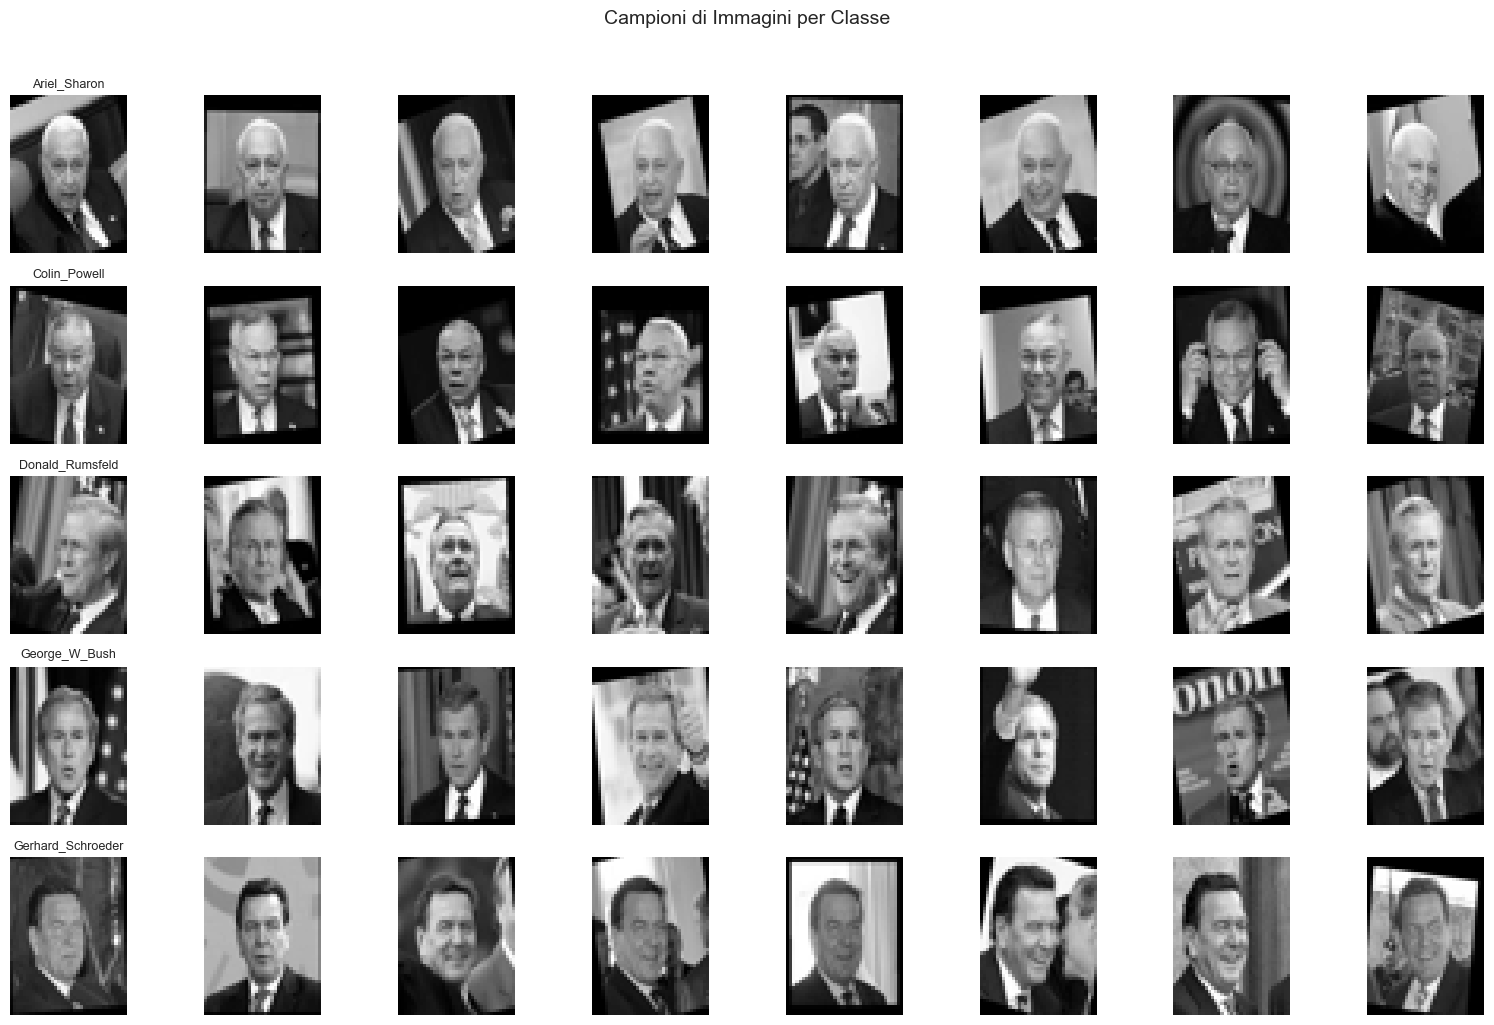

In [7]:
n_display = min(5, n_classes)
fig, axes = plt.subplots(n_display, 8, figsize=(16, 2*n_display))
for i in range(n_display):
    class_indices = np.where(y == i)[0]
    sample_indices = class_indices[:8]
    for j, idx in enumerate(sample_indices):
        axes[i, j].imshow(images[idx], cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'{target_names[i][:20]}', fontsize=9)
plt.suptitle('Campioni di Immagini per Classe', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('sample_faces.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Preprocessing delle Immagini

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} campioni")
print(f"Test set: {X_test.shape[0]} campioni")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"\nDopo standardizzazione:")
print(f"  Training - Media: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.4f}")
print(f"  Test - Media: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.4f}")

Training set: 966 campioni
Test set: 322 campioni

Dopo standardizzazione:
  Training - Media: -0.000000, Std: 1.0000
  Test - Media: -0.036792, Std: 0.9802


## 5. PCA tramite SVD e Analisi della Varianza Spiegata

In [9]:
print("Applicazione SVD per PCA...")
X_centered = X_train_scaled - X_train_scaled.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

explained_variance = (S ** 2) / (X_centered.shape[0] - 1)
total_variance = explained_variance.sum()
explained_variance_ratio = explained_variance / total_variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print(f"\nRisultati SVD:")
print(f"  Shape U: {U.shape}")
print(f"  Shape S (valori singolari): {S.shape}")
print(f"  Shape Vt (componenti principali): {Vt.shape}")
print(f"\nPrime 10 varianze spiegate (%):")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"  PC{i+1}: {explained_variance_ratio[i]*100:.2f}% (cumulativa: {cumulative_variance_ratio[i]*100:.2f}%)")

Applicazione SVD per PCA...

Risultati SVD:
  Shape U: (966, 966)
  Shape S (valori singolari): (966,)
  Shape Vt (componenti principali): (966, 1850)

Prime 10 varianze spiegate (%):
  PC1: 20.31% (cumulativa: 20.31%)
  PC2: 6.12% (cumulativa: 26.43%)
  PC3: 5.60% (cumulativa: 32.04%)
  PC4: 5.32% (cumulativa: 37.36%)
  PC5: 4.25% (cumulativa: 41.60%)
  PC6: 3.97% (cumulativa: 45.57%)
  PC7: 3.28% (cumulativa: 48.85%)
  PC8: 2.32% (cumulativa: 51.17%)
  PC9: 2.12% (cumulativa: 53.29%)
  PC10: 1.90% (cumulativa: 55.19%)


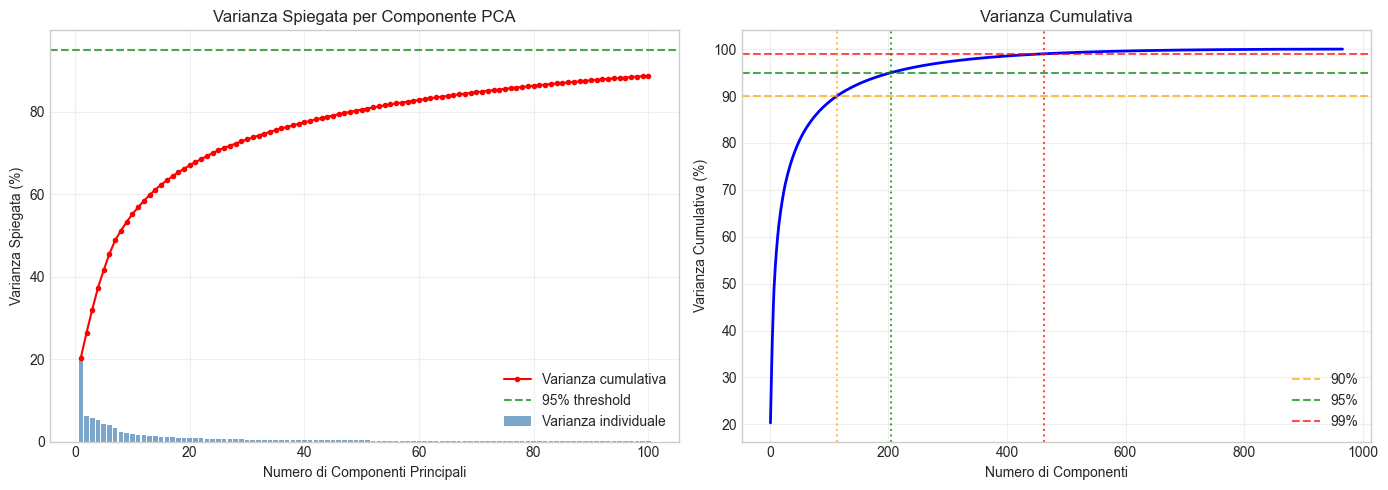


Componenti necessarie per:
  90% varianza: 114 componenti
  95% varianza: 205 componenti
  99% varianza: 462 componenti


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
n_components_plot = min(100, len(explained_variance_ratio))

axes[0].bar(range(1, n_components_plot+1), explained_variance_ratio[:n_components_plot]*100, color='steelblue', alpha=0.7, label='Varianza individuale')
axes[0].plot(range(1, n_components_plot+1), cumulative_variance_ratio[:n_components_plot]*100, 'r-o', markersize=3, label='Varianza cumulativa')
axes[0].axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% threshold')
axes[0].set_xlabel('Numero di Componenti Principali')
axes[0].set_ylabel('Varianza Spiegata (%)')
axes[0].set_title('Varianza Spiegata per Componente PCA')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio*100, 'b-', linewidth=2)
axes[1].axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90%')
axes[1].axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95%')
axes[1].axhline(y=99, color='red', linestyle='--', alpha=0.7, label='99%')
n_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
n_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
n_99 = np.argmax(cumulative_variance_ratio >= 0.99) + 1
axes[1].axvline(x=n_90, color='orange', linestyle=':', alpha=0.7)
axes[1].axvline(x=n_95, color='green', linestyle=':', alpha=0.7)
axes[1].axvline(x=n_99, color='red', linestyle=':', alpha=0.7)
axes[1].set_xlabel('Numero di Componenti')
axes[1].set_ylabel('Varianza Cumulativa (%)')
axes[1].set_title('Varianza Cumulativa')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComponenti necessarie per:")
print(f"  90% varianza: {n_90} componenti")
print(f"  95% varianza: {n_95} componenti")
print(f"  99% varianza: {n_99} componenti")

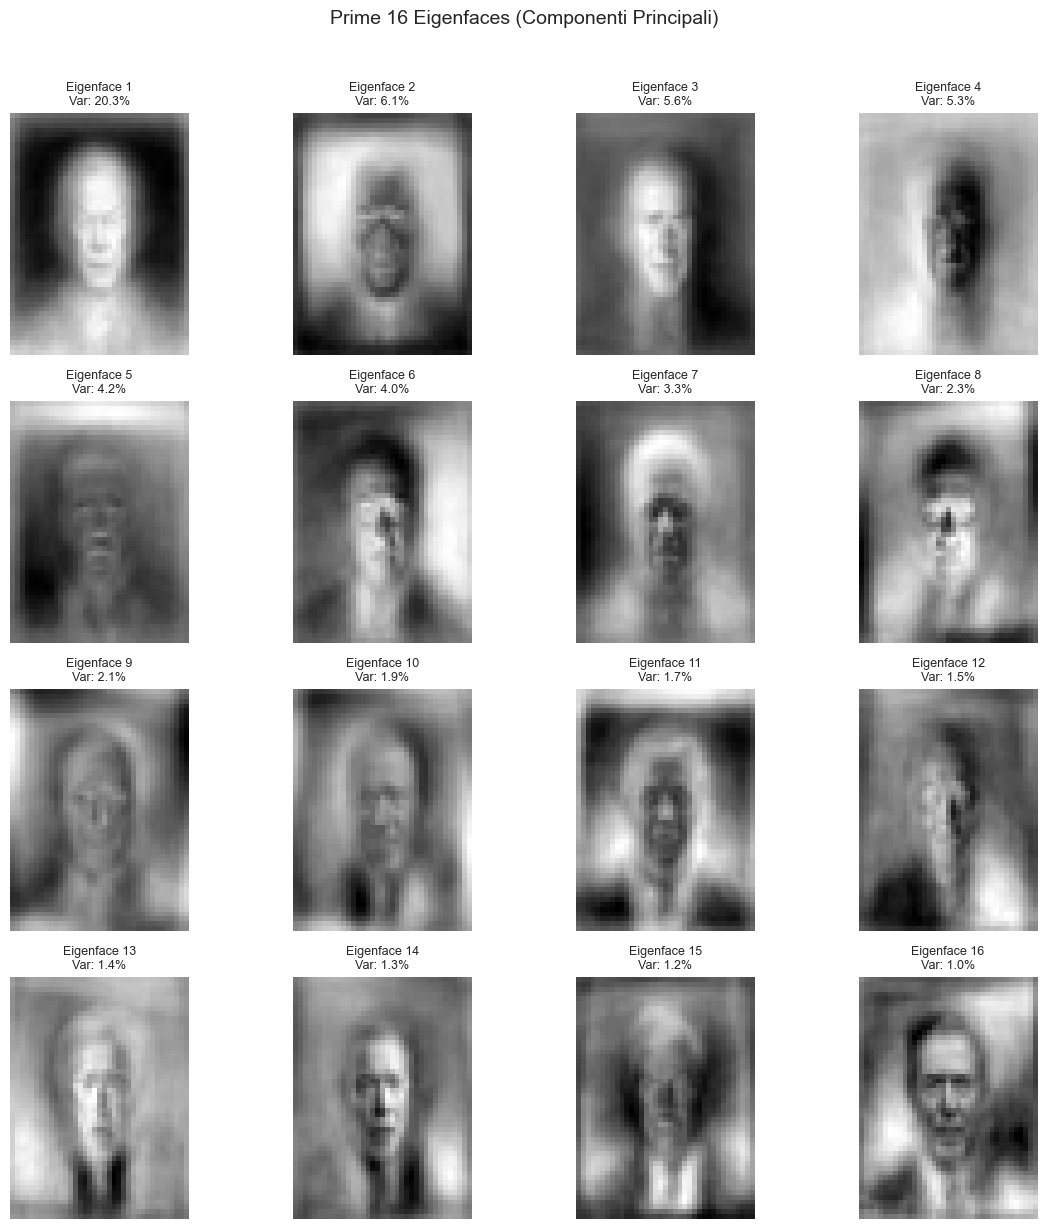

In [11]:
n_eigenfaces = 16
eigenfaces = Vt[:n_eigenfaces].reshape((n_eigenfaces, h, w))

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f'Eigenface {i+1}\nVar: {explained_variance_ratio[i]*100:.1f}%', fontsize=9)
    ax.axis('off')
plt.suptitle('Prime 16 Eigenfaces (Componenti Principali)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('eigenfaces.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
pca_components_list = [50, 100, 150]
pca_models = {}
X_train_pca = {}
X_test_pca = {}

print("Applicazione PCA con diversi numeri di componenti:")
for n_comp in pca_components_list:
    pca = PCA(n_components=n_comp, svd_solver='full', random_state=42)
    X_train_pca[n_comp] = pca.fit_transform(X_train_scaled)
    X_test_pca[n_comp] = pca.transform(X_test_scaled)
    pca_models[n_comp] = pca
    var_explained = pca.explained_variance_ratio_.sum() * 100
    reduction = (1 - n_comp / n_features) * 100
    print(f"  {n_comp} componenti: {var_explained:.2f}% varianza, {reduction:.1f}% riduzione dimensionale")

Applicazione PCA con diversi numeri di componenti:
  50 componenti: 80.54% varianza, 97.3% riduzione dimensionale
  100 componenti: 88.75% varianza, 94.6% riduzione dimensionale
  150 componenti: 92.59% varianza, 91.9% riduzione dimensionale


## 6. Autoencoder per Estrazione Caratteristiche Non Lineari

In [13]:
class Autoencoder:
    def __init__(self, input_dim, encoding_dims, learning_rate=0.001, activation='relu'):
        self.input_dim = input_dim
        self.encoding_dims = encoding_dims
        self.learning_rate = learning_rate
        self.activation = activation
        self.weights = []
        self.biases = []
        self.training_history = {'loss': []}
        encoder_dims = [input_dim] + encoding_dims
        decoder_dims = encoding_dims[::-1] + [input_dim]
        all_dims = encoder_dims + decoder_dims[1:]
        for i in range(len(all_dims) - 1):
            limit = np.sqrt(6 / (all_dims[i] + all_dims[i+1]))
            W = np.random.uniform(-limit, limit, (all_dims[i], all_dims[i+1]))
            b = np.zeros((1, all_dims[i+1]))
            self.weights.append(W)
            self.biases.append(b)
        self.encoder_layers = len(encoding_dims)
    
    def _activate(self, x, derivative=False):
        if self.activation == 'relu':
            if derivative:
                return (x > 0).astype(float)
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            if derivative:
                return sig * (1 - sig)
            return sig
        elif self.activation == 'tanh':
            if derivative:
                return 1 - np.tanh(x) ** 2
            return np.tanh(x)
        else:
            return np.ones_like(x) if derivative else x
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        current = X
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = current @ W + b
            self.z_values.append(z)
            current = z if i == len(self.weights) - 1 else self._activate(z)
            self.activations.append(current)
        return current
    
    def backward(self, X, y):
        m = X.shape[0]
        grads_w, grads_b = [], []
        delta = (self.activations[-1] - y) / m
        for i in range(len(self.weights) - 1, -1, -1):
            grads_w.insert(0, self.activations[i].T @ delta)
            grads_b.insert(0, np.sum(delta, axis=0, keepdims=True))
            if i > 0:
                delta = (delta @ self.weights[i].T) * self._activate(self.z_values[i-1], derivative=True)
        return grads_w, grads_b
    
    def fit(self, X, epochs=100, batch_size=32, verbose=True):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            epoch_loss, n_batches = 0, 0
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                output = self.forward(X_batch)
                batch_loss = np.mean((output - X_batch) ** 2)
                epoch_loss += batch_loss
                n_batches += 1
                grads_w, grads_b = self.backward(X_batch, X_batch)
                for j in range(len(self.weights)):
                    self.weights[j] -= self.learning_rate * grads_w[j]
                    self.biases[j] -= self.learning_rate * grads_b[j]
            avg_loss = epoch_loss / n_batches
            self.training_history['loss'].append(avg_loss)
            if verbose and (epoch + 1) % 20 == 0:
                print(f"  Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
    
    def encode(self, X):
        current = X
        for i in range(self.encoder_layers):
            z = current @ self.weights[i] + self.biases[i]
            current = self._activate(z)
        return current
    
    def decode(self, encoded):
        current = encoded
        for i in range(self.encoder_layers, len(self.weights)):
            z = current @ self.weights[i] + self.biases[i]
            current = z if i == len(self.weights) - 1 else self._activate(z)
        return current
    
    def reconstruct(self, X):
        return self.forward(X)

In [14]:
encoding_dim = 100
encoding_dims = [512, 256, encoding_dim]

print(f"Architettura Autoencoder:")
print(f"  Encoder: {n_features} -> 512 -> 256 -> {encoding_dim}")
print(f"  Decoder: {encoding_dim} -> 256 -> 512 -> {n_features}")
print(f"\nAddestramento Autoencoder...")

autoencoder = Autoencoder(input_dim=n_features, encoding_dims=encoding_dims, learning_rate=0.001, activation='relu')
autoencoder.fit(X_train_scaled, epochs=100, batch_size=32, verbose=True)

X_train_ae = autoencoder.encode(X_train_scaled)
X_test_ae = autoencoder.encode(X_test_scaled)

print(f"\nDimensione features estratte: {X_train_ae.shape[1]}")
print(f"Riduzione dimensionale: {(1 - encoding_dim / n_features) * 100:.1f}%")

Architettura Autoencoder:
  Encoder: 1850 -> 512 -> 256 -> 100
  Decoder: 100 -> 256 -> 512 -> 1850

Addestramento Autoencoder...
  Epoch 20/100, Loss: 0.438539
  Epoch 40/100, Loss: 0.357269
  Epoch 60/100, Loss: 0.300110
  Epoch 80/100, Loss: 0.257501
  Epoch 100/100, Loss: 0.227985

Dimensione features estratte: 100
Riduzione dimensionale: 94.6%


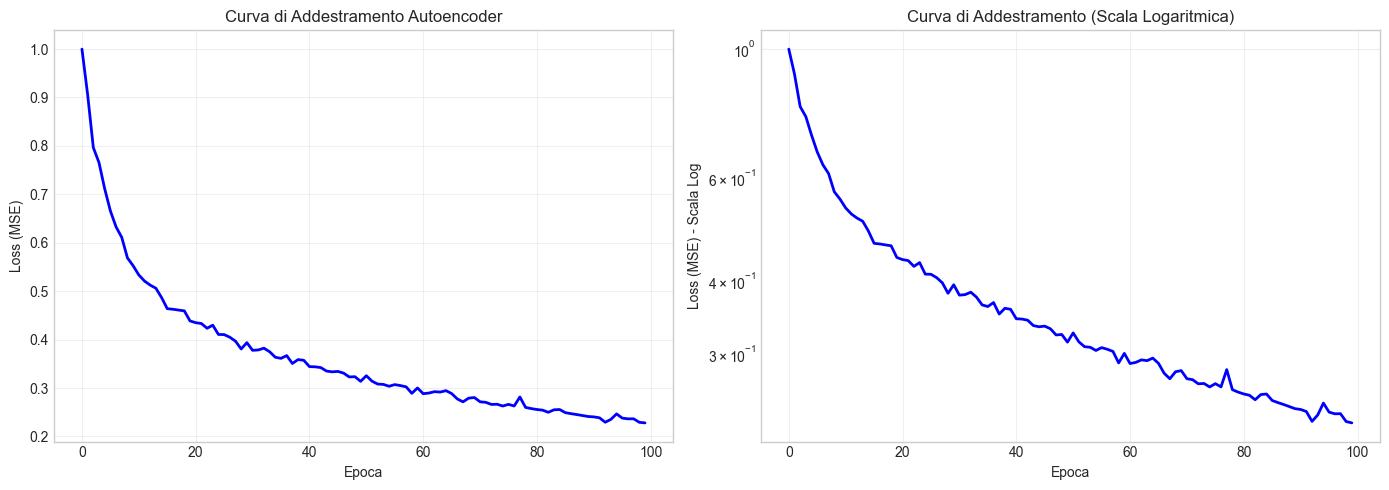

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(autoencoder.training_history['loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Curva di Addestramento Autoencoder')
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(autoencoder.training_history['loss'], 'b-', linewidth=2)
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Loss (MSE) - Scala Log')
axes[1].set_title('Curva di Addestramento (Scala Logaritmica)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('autoencoder_training.png', dpi=150, bbox_inches='tight')
plt.show()

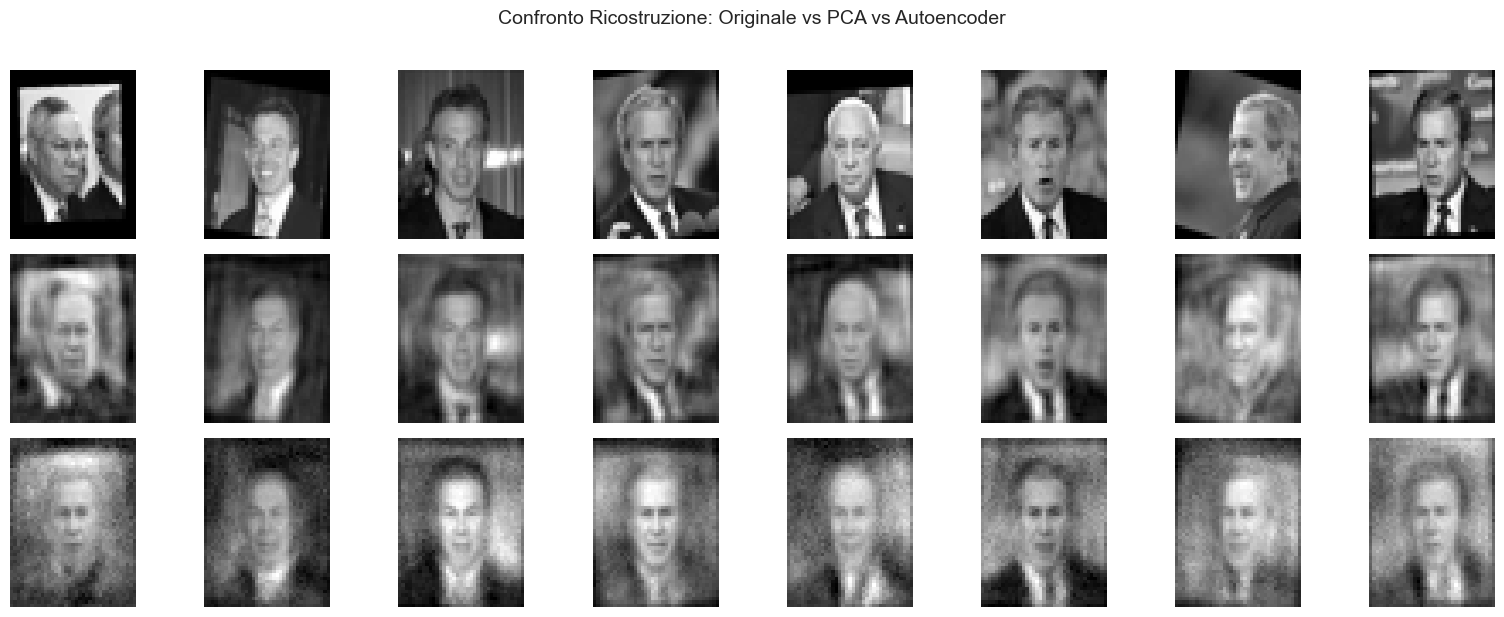


Errore di ricostruzione (MSE):
  PCA (100 componenti): 0.123021
  Autoencoder (100 dim): 0.313511


In [16]:
n_samples_viz = 8
sample_indices = np.random.choice(len(X_test_scaled), n_samples_viz, replace=False)
reconstructed_ae = autoencoder.reconstruct(X_test_scaled[sample_indices])

pca_viz = pca_models[100]
X_test_pca_viz = pca_viz.transform(X_test_scaled[sample_indices])
reconstructed_pca = pca_viz.inverse_transform(X_test_pca_viz)

fig, axes = plt.subplots(3, n_samples_viz, figsize=(16, 6))
for i in range(n_samples_viz):
    original = scaler.inverse_transform(X_test_scaled[sample_indices[i]].reshape(1, -1)).reshape(h, w)
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Originale', fontsize=10)
    
    rec_pca = scaler.inverse_transform(reconstructed_pca[i].reshape(1, -1)).reshape(h, w)
    axes[1, i].imshow(rec_pca, cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('PCA (100)', fontsize=10)
    
    rec_ae = scaler.inverse_transform(reconstructed_ae[i].reshape(1, -1)).reshape(h, w)
    axes[2, i].imshow(rec_ae, cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel(f'AE ({encoding_dim})', fontsize=10)

plt.suptitle('Confronto Ricostruzione: Originale vs PCA vs Autoencoder', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('reconstruction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

mse_pca = np.mean((X_test_scaled[sample_indices] - reconstructed_pca) ** 2)
mse_ae = np.mean((X_test_scaled[sample_indices] - reconstructed_ae) ** 2)
print(f"\nErrore di ricostruzione (MSE):")
print(f"  PCA (100 componenti): {mse_pca:.6f}")
print(f"  Autoencoder ({encoding_dim} dim): {mse_ae:.6f}")

## 7. Addestramento Classificatori con K-Fold Cross Validation e Grid Search

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']}
nn_param_grid = {'hidden_layer_sizes': [(100,), (100, 50), (200, 100)], 'alpha': [0.0001, 0.001], 'learning_rate_init': [0.001, 0.01]}
results = {}

In [18]:
print("ADDESTRAMENTO SU DATI ORIGINALI (SENZA RIDUZIONE)")

print("\nSVM su dati originali...")
svm_original = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
svm_original.fit(X_train_scaled, y_train)
print(f"  Migliori parametri: {svm_original.best_params_}")
print(f"  CV Accuracy: {svm_original.best_score_:.4f}")
results['SVM_Original'] = {'model': svm_original.best_estimator_, 'cv_score': svm_original.best_score_, 'params': svm_original.best_params_, 'n_features': n_features}

print("\nNeural Network su dati originali...")
nn_original = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), nn_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
nn_original.fit(X_train_scaled, y_train)
print(f"  Migliori parametri: {nn_original.best_params_}")
print(f"  CV Accuracy: {nn_original.best_score_:.4f}")
results['NN_Original'] = {'model': nn_original.best_estimator_, 'cv_score': nn_original.best_score_, 'params': nn_original.best_params_, 'n_features': n_features}

ADDESTRAMENTO SU DATI ORIGINALI (SENZA RIDUZIONE)

SVM su dati originali...
  Migliori parametri: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
  CV Accuracy: 0.8406

Neural Network su dati originali...
  Migliori parametri: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
  CV Accuracy: 0.8064


In [19]:
print("\nADDESTRAMENTO SU FEATURES PCA")

for n_comp in pca_components_list:
    print(f"\n--- PCA con {n_comp} componenti ---")
    
    print(f"  SVM...")
    svm_pca = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    svm_pca.fit(X_train_pca[n_comp], y_train)
    print(f"    Migliori parametri: {svm_pca.best_params_}")
    print(f"    CV Accuracy: {svm_pca.best_score_:.4f}")
    results[f'SVM_PCA_{n_comp}'] = {'model': svm_pca.best_estimator_, 'cv_score': svm_pca.best_score_, 'params': svm_pca.best_params_, 'n_features': n_comp}
    
    print(f"  Neural Network...")
    nn_pca = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), nn_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    nn_pca.fit(X_train_pca[n_comp], y_train)
    print(f"    Migliori parametri: {nn_pca.best_params_}")
    print(f"    CV Accuracy: {nn_pca.best_score_:.4f}")
    results[f'NN_PCA_{n_comp}'] = {'model': nn_pca.best_estimator_, 'cv_score': nn_pca.best_score_, 'params': nn_pca.best_params_, 'n_features': n_comp}


ADDESTRAMENTO SU FEATURES PCA

--- PCA con 50 componenti ---
  SVM...
    Migliori parametri: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
    CV Accuracy: 0.7029
  Neural Network...
    Migliori parametri: {'alpha': 0.001, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.01}
    CV Accuracy: 0.7319

--- PCA con 100 componenti ---
  SVM...
    Migliori parametri: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    CV Accuracy: 0.7568
  Neural Network...
    Migliori parametri: {'alpha': 0.0001, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.01}
    CV Accuracy: 0.7992

--- PCA con 150 componenti ---
  SVM...
    Migliori parametri: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    CV Accuracy: 0.8117
  Neural Network...
    Migliori parametri: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
    CV Accuracy: 0.8292


In [20]:
print("\nADDESTRAMENTO SU FEATURES AUTOENCODER")
print(f"\n--- Autoencoder con {encoding_dim} dimensioni ---")

print(f"  SVM...")
svm_ae = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
svm_ae.fit(X_train_ae, y_train)
print(f"    Migliori parametri: {svm_ae.best_params_}")
print(f"    CV Accuracy: {svm_ae.best_score_:.4f}")
results[f'SVM_AE_{encoding_dim}'] = {'model': svm_ae.best_estimator_, 'cv_score': svm_ae.best_score_, 'params': svm_ae.best_params_, 'n_features': encoding_dim}

print(f"  Neural Network...")
nn_ae = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), nn_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
nn_ae.fit(X_train_ae, y_train)
print(f"    Migliori parametri: {nn_ae.best_params_}")
print(f"    CV Accuracy: {nn_ae.best_score_:.4f}")
results[f'NN_AE_{encoding_dim}'] = {'model': nn_ae.best_estimator_, 'cv_score': nn_ae.best_score_, 'params': nn_ae.best_params_, 'n_features': encoding_dim}


ADDESTRAMENTO SU FEATURES AUTOENCODER

--- Autoencoder con 100 dimensioni ---
  SVM...
    Migliori parametri: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
    CV Accuracy: 0.6439
  Neural Network...
    Migliori parametri: {'alpha': 0.001, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.001}
    CV Accuracy: 0.6532


## 8. Calcolo delle Metriche di Classificazione

In [21]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    return {
        'name': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'y_pred': y_pred
    }

all_metrics = []
metrics = evaluate_model(results['SVM_Original']['model'], X_test_scaled, y_test, 'SVM_Original')
all_metrics.append(metrics)
results['SVM_Original']['metrics'] = metrics

metrics = evaluate_model(results['NN_Original']['model'], X_test_scaled, y_test, 'NN_Original')
all_metrics.append(metrics)
results['NN_Original']['metrics'] = metrics

for n_comp in pca_components_list:
    metrics = evaluate_model(results[f'SVM_PCA_{n_comp}']['model'], X_test_pca[n_comp], y_test, f'SVM_PCA_{n_comp}')
    all_metrics.append(metrics)
    results[f'SVM_PCA_{n_comp}']['metrics'] = metrics
    
    metrics = evaluate_model(results[f'NN_PCA_{n_comp}']['model'], X_test_pca[n_comp], y_test, f'NN_PCA_{n_comp}')
    all_metrics.append(metrics)
    results[f'NN_PCA_{n_comp}']['metrics'] = metrics

metrics = evaluate_model(results[f'SVM_AE_{encoding_dim}']['model'], X_test_ae, y_test, f'SVM_AE_{encoding_dim}')
all_metrics.append(metrics)
results[f'SVM_AE_{encoding_dim}']['metrics'] = metrics

metrics = evaluate_model(results[f'NN_AE_{encoding_dim}']['model'], X_test_ae, y_test, f'NN_AE_{encoding_dim}')
all_metrics.append(metrics)
results[f'NN_AE_{encoding_dim}']['metrics'] = metrics

In [22]:
metrics_df = pd.DataFrame([{
    'Modello': m['name'],
    'Accuracy': m['accuracy'],
    'Precision (macro)': m['precision_macro'],
    'Recall (macro)': m['recall_macro'],
    'F1 (macro)': m['f1_macro'],
    'Precision (weighted)': m['precision_weighted'],
    'Recall (weighted)': m['recall_weighted'],
    'F1 (weighted)': m['f1_weighted']
} for m in all_metrics])

print("\nTABELLA RIASSUNTIVA DELLE METRICHE DI CLASSIFICAZIONE")
print(metrics_df.to_string(index=False, float_format='%.4f'))
metrics_df.to_csv('classification_metrics.csv', index=False)


TABELLA RIASSUNTIVA DELLE METRICHE DI CLASSIFICAZIONE
     Modello  Accuracy  Precision (macro)  Recall (macro)  F1 (macro)  Precision (weighted)  Recall (weighted)  F1 (weighted)
SVM_Original    0.8820             0.8987          0.8212      0.8497                0.8871             0.8820         0.8795
 NN_Original    0.8261             0.8023          0.7626      0.7787                0.8283             0.8261         0.8248
  SVM_PCA_50    0.7050             0.6898          0.5724      0.6087                0.7121             0.7050         0.6965
   NN_PCA_50    0.6832             0.6109          0.5984      0.6028                0.6828             0.6832         0.6817
 SVM_PCA_100    0.7733             0.7420          0.7185      0.7260                0.7733             0.7733         0.7714
  NN_PCA_100    0.8261             0.7857          0.7671      0.7752                0.8238             0.8261         0.8241
 SVM_PCA_150    0.8106             0.8223          0.7539      

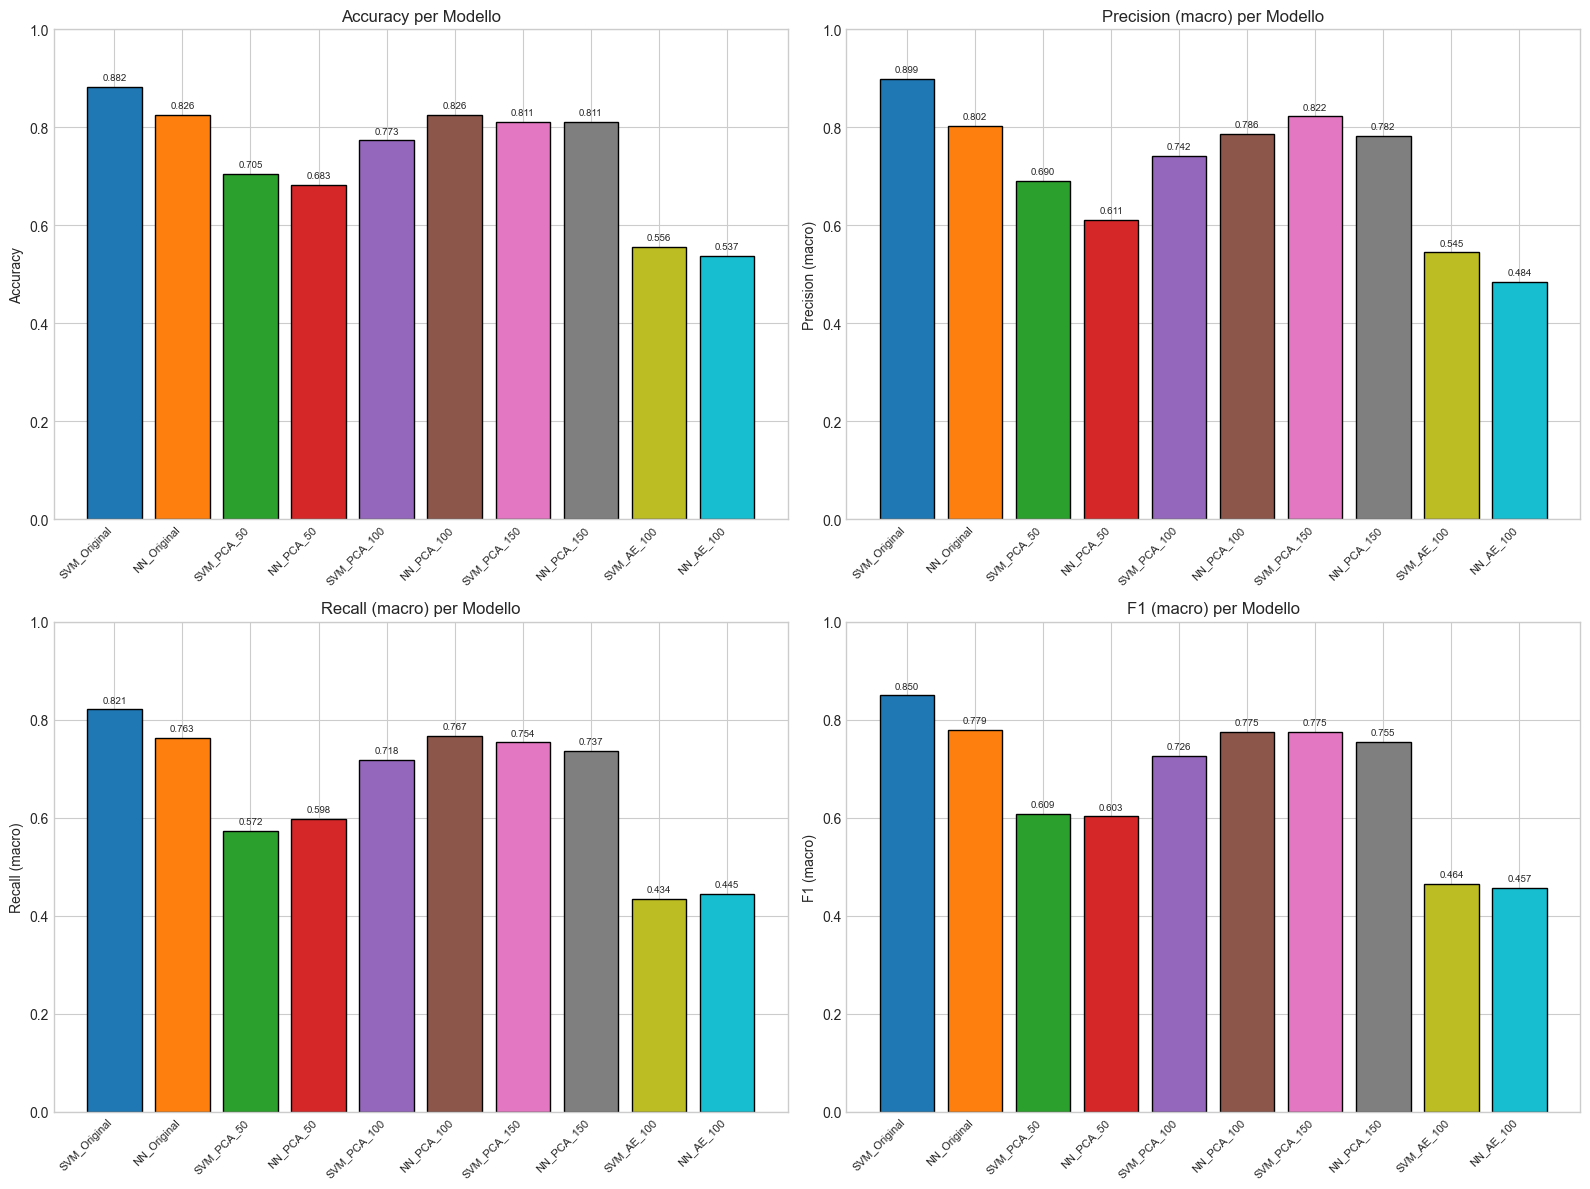

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_to_plot = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)']
colors = plt.cm.tab10(np.linspace(0, 1, len(metrics_df)))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(range(len(metrics_df)), metrics_df[metric], color=colors, edgecolor='black')
    ax.set_xticks(range(len(metrics_df)))
    ax.set_xticklabels(metrics_df['Modello'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} per Modello')
    ax.set_ylim([0, 1])
    for bar, val in zip(bars, metrics_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('classification_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


Miglior modello: SVM_Original
Accuracy: 0.8820


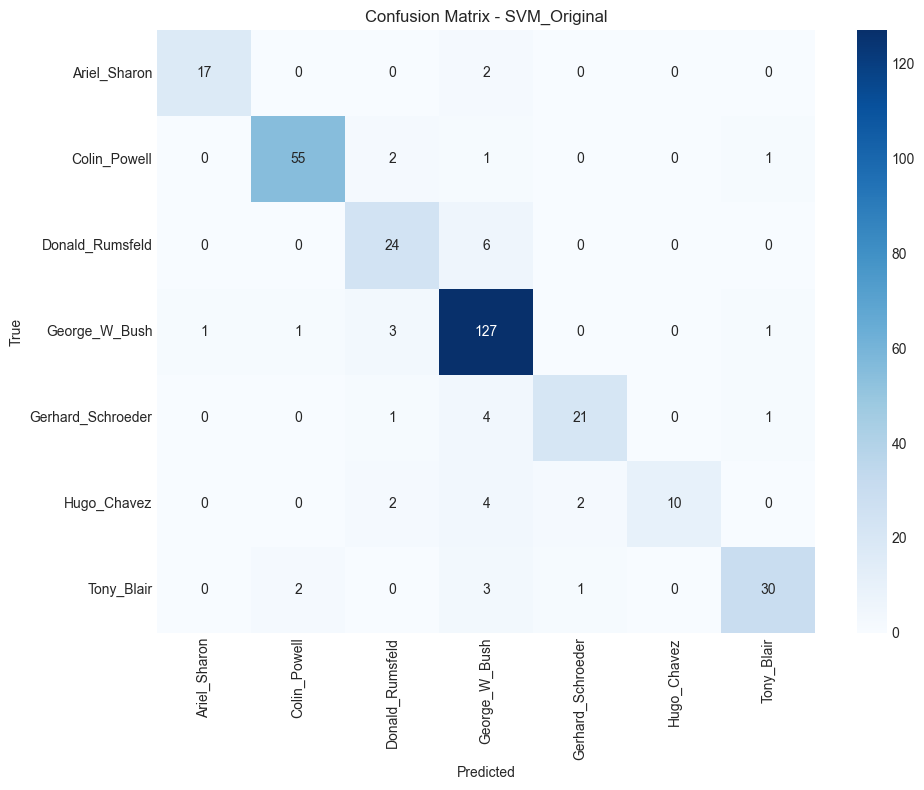


Classification Report - SVM_Original:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.94      0.89      0.92        19
     Colin_Powell       0.95      0.93      0.94        59
  Donald_Rumsfeld       0.75      0.80      0.77        30
    George_W_Bush       0.86      0.95      0.91       133
Gerhard_Schroeder       0.88      0.78      0.82        27
      Hugo_Chavez       1.00      0.56      0.71        18
       Tony_Blair       0.91      0.83      0.87        36

         accuracy                           0.88       322
        macro avg       0.90      0.82      0.85       322
     weighted avg       0.89      0.88      0.88       322



In [24]:
best_model_name = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Modello']
best_model_metrics = [m for m in all_metrics if m['name'] == best_model_name][0]

print(f"\nMiglior modello: {best_model_name}")
print(f"Accuracy: {best_model_metrics['accuracy']:.4f}")

cm = confusion_matrix(y_test, best_model_metrics['y_pred'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix_best.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, best_model_metrics['y_pred'], target_names=target_names, zero_division=0))

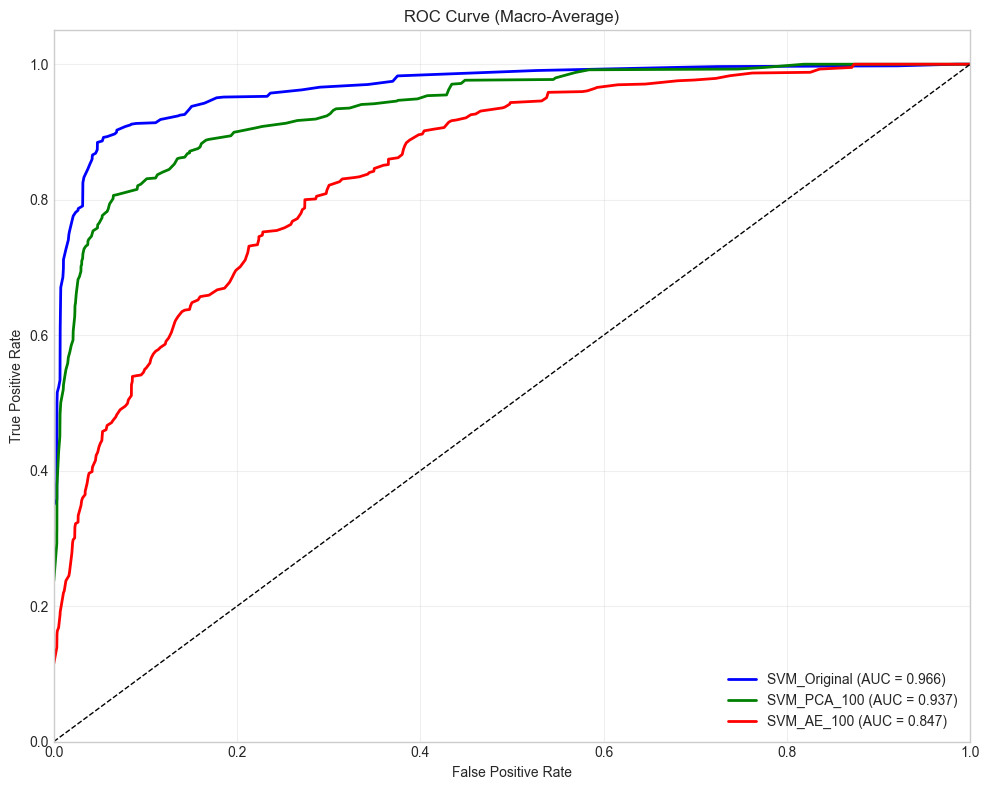

In [25]:
y_test_bin = label_binarize(y_test, classes=np.unique(y))
models_for_roc = [('SVM_Original', X_test_scaled), ('SVM_PCA_100', X_test_pca[100]), (f'SVM_AE_{encoding_dim}', X_test_ae)]

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']

for (name, X_test_data), color in zip(models_for_roc, colors):
    model = results[name]['model']
    if hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test_data)
    else:
        y_score = model.predict_proba(X_test_data)
    
    if len(y_score.shape) == 1:
        y_score = np.column_stack([-y_score, y_score])
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    mean_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color=color, linewidth=2, label=f'{name} (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Macro-Average)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Verifica Facciale

In [26]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def create_pairs(X, y, n_pairs=500):
    positive_pairs, negative_pairs = [], []
    unique_classes = np.unique(y)
    class_indices = {c: np.where(y == c)[0] for c in unique_classes}
    
    for _ in range(n_pairs):
        c = np.random.choice(unique_classes)
        if len(class_indices[c]) >= 2:
            idx1, idx2 = np.random.choice(class_indices[c], 2, replace=False)
            positive_pairs.append((X[idx1], X[idx2], 1))
    
    for _ in range(n_pairs):
        c1, c2 = np.random.choice(unique_classes, 2, replace=False)
        idx1 = np.random.choice(class_indices[c1])
        idx2 = np.random.choice(class_indices[c2])
        negative_pairs.append((X[idx1], X[idx2], 0))
    
    return positive_pairs + negative_pairs

def evaluate_verification(pairs, metric='cosine'):
    similarities, labels = [], []
    for a, b, label in pairs:
        sim = cosine_similarity(a, b) if metric == 'cosine' else -euclidean_distance(a, b)
        similarities.append(sim)
        labels.append(label)
    return np.array(similarities), np.array(labels)

In [27]:
print("VERIFICA FACCIALE")

pairs_original = create_pairs(X_test_scaled, y_test, n_pairs=300)
pairs_pca = create_pairs(X_test_pca[100], y_test, n_pairs=300)
pairs_ae = create_pairs(X_test_ae, y_test, n_pairs=300)

verification_results = {}

for name, pairs in [('Original', pairs_original), ('PCA_100', pairs_pca), (f'AE_{encoding_dim}', pairs_ae)]:
    for metric in ['cosine', 'euclidean']:
        sim, labels = evaluate_verification(pairs, metric)
        fpr, tpr, thresholds = roc_curve(labels, sim)
        roc_auc = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        predictions = (sim >= optimal_threshold).astype(int)
        acc = accuracy_score(labels, predictions)
        verification_results[f'{name}_{metric}'] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc, 'accuracy': acc, 'threshold': optimal_threshold}
        print(f"\n{name} - {metric.capitalize()} Similarity:")
        print(f"  AUC: {roc_auc:.4f}, Accuracy: {acc:.4f}, Optimal Threshold: {optimal_threshold:.4f}")

VERIFICA FACCIALE

Original - Cosine Similarity:
  AUC: 0.5471, Accuracy: 0.5517, Optimal Threshold: 0.2132

Original - Euclidean Similarity:
  AUC: 0.5523, Accuracy: 0.5517, Optimal Threshold: -57.1082

PCA_100 - Cosine Similarity:
  AUC: 0.5976, Accuracy: 0.5783, Optimal Threshold: 0.2367

PCA_100 - Euclidean Similarity:
  AUC: 0.5950, Accuracy: 0.5733, Optimal Threshold: -42.0705

AE_100 - Cosine Similarity:
  AUC: 0.5654, Accuracy: 0.5550, Optimal Threshold: 0.5146

AE_100 - Euclidean Similarity:
  AUC: 0.5387, Accuracy: 0.5467, Optimal Threshold: -19.3124


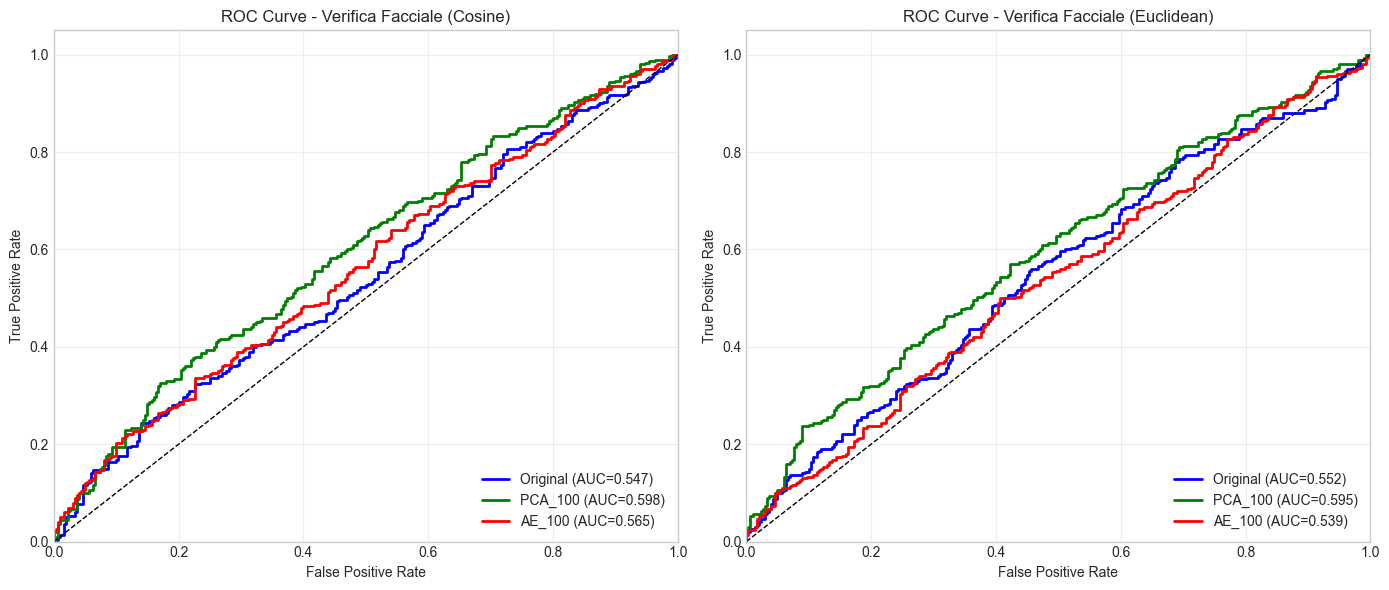

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for metric, ax in zip(['cosine', 'euclidean'], axes):
    for name, color in [('Original', 'blue'), ('PCA_100', 'green'), (f'AE_{encoding_dim}', 'red')]:
        key = f'{name}_{metric}'
        res = verification_results[key]
        ax.plot(res['fpr'], res['tpr'], color=color, linewidth=2, label=f'{name} (AUC={res["auc"]:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - Verifica Facciale ({metric.capitalize()})')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('verification_roc.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
verification_df = pd.DataFrame([{
    'Features': name.split('_')[0] if 'AE' not in name else 'AE',
    'Metric': name.split('_')[-1].capitalize(),
    'AUC': res['auc'],
    'Accuracy': res['accuracy'],
    'Threshold': res['threshold']
} for name, res in verification_results.items()])

print("\nCONFRONTO METRICHE DI SIMILARITÀ PER VERIFICA FACCIALE")
print(verification_df.to_string(index=False, float_format='%.4f'))
verification_df.to_csv('verification_metrics.csv', index=False)


CONFRONTO METRICHE DI SIMILARITÀ PER VERIFICA FACCIALE
Features    Metric    AUC  Accuracy  Threshold
Original    Cosine 0.5471    0.5517     0.2132
Original Euclidean 0.5523    0.5517   -57.1082
     PCA    Cosine 0.5976    0.5783     0.2367
     PCA Euclidean 0.5950    0.5733   -42.0705
      AE    Cosine 0.5654    0.5550     0.5146
      AE Euclidean 0.5387    0.5467   -19.3124


## 10. Esperimenti di Ablazione e Comparativi

In [30]:
print("STUDIO DI ABLAZIONE: IMPATTO DEL NUMERO DI COMPONENTI PCA")

ablation_components = [10, 25, 50, 75, 100, 125, 150, 175, 200]
ablation_results = []

for n_comp in ablation_components:
    pca_abl = PCA(n_components=n_comp, random_state=42)
    X_train_abl = pca_abl.fit_transform(X_train_scaled)
    X_test_abl = pca_abl.transform(X_test_scaled)
    svm_abl = SVC(C=1, kernel='rbf', gamma='scale', random_state=42)
    svm_abl.fit(X_train_abl, y_train)
    y_pred_abl = svm_abl.predict(X_test_abl)
    acc = accuracy_score(y_test, y_pred_abl)
    var_explained = pca_abl.explained_variance_ratio_.sum()
    ablation_results.append({'n_components': n_comp, 'accuracy': acc, 'variance_explained': var_explained})
    print(f"  {n_comp} componenti: Accuracy={acc:.4f}, Varianza={var_explained*100:.2f}%")

ablation_df = pd.DataFrame(ablation_results)

STUDIO DI ABLAZIONE: IMPATTO DEL NUMERO DI COMPONENTI PCA
  10 componenti: Accuracy=0.4752, Varianza=55.19%
  25 componenti: Accuracy=0.5807, Varianza=70.66%
  50 componenti: Accuracy=0.6273, Varianza=80.53%
  75 componenti: Accuracy=0.6646, Varianza=85.56%
  100 componenti: Accuracy=0.6615, Varianza=88.69%
  125 componenti: Accuracy=0.6677, Varianza=90.90%
  150 componenti: Accuracy=0.6739, Varianza=92.53%
  175 componenti: Accuracy=0.6770, Varianza=93.78%
  200 componenti: Accuracy=0.6708, Varianza=94.79%


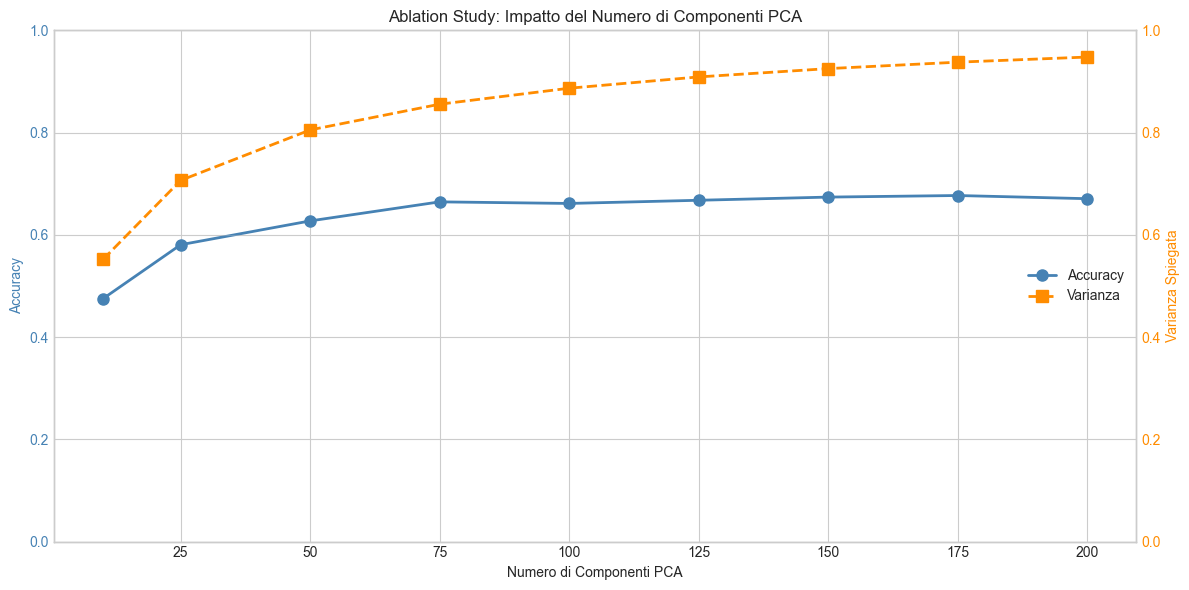

In [31]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Numero di Componenti PCA')
ax1.set_ylabel('Accuracy', color='steelblue')
ax1.plot(ablation_df['n_components'], ablation_df['accuracy'], 'o-', color='steelblue', linewidth=2, markersize=8, label='Accuracy')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_ylim([0, 1])

ax2 = ax1.twinx()
ax2.set_ylabel('Varianza Spiegata', color='darkorange')
ax2.plot(ablation_df['n_components'], ablation_df['variance_explained'], 's--', color='darkorange', linewidth=2, markersize=8, label='Varianza')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim([0, 1])

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
plt.title('Ablation Study: Impatto del Numero di Componenti PCA')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ablation_pca_components.png', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
print("\nCONFRONTO CLASSIFICATORI: SVM vs NEURAL NETWORK")

comparison_data = []
for key, val in results.items():
    classifier = 'SVM' if 'SVM' in key else 'NN'
    features = key.replace('SVM_', '').replace('NN_', '')
    comparison_data.append({'Classifier': classifier, 'Features': features, 'CV_Score': val['cv_score'], 'Test_Accuracy': val['metrics']['accuracy'], 'N_Features': val['n_features']})

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format='%.4f'))


CONFRONTO CLASSIFICATORI: SVM vs NEURAL NETWORK
Classifier Features  CV_Score  Test_Accuracy  N_Features
       SVM Original    0.8406         0.8820        1850
        NN Original    0.8064         0.8261        1850
       SVM   PCA_50    0.7029         0.7050          50
        NN   PCA_50    0.7319         0.6832          50
       SVM  PCA_100    0.7568         0.7733         100
        NN  PCA_100    0.7992         0.8261         100
       SVM  PCA_150    0.8117         0.8106         150
        NN  PCA_150    0.8292         0.8106         150
       SVM   AE_100    0.6439         0.5559         100
        NN   AE_100    0.6532         0.5373         100


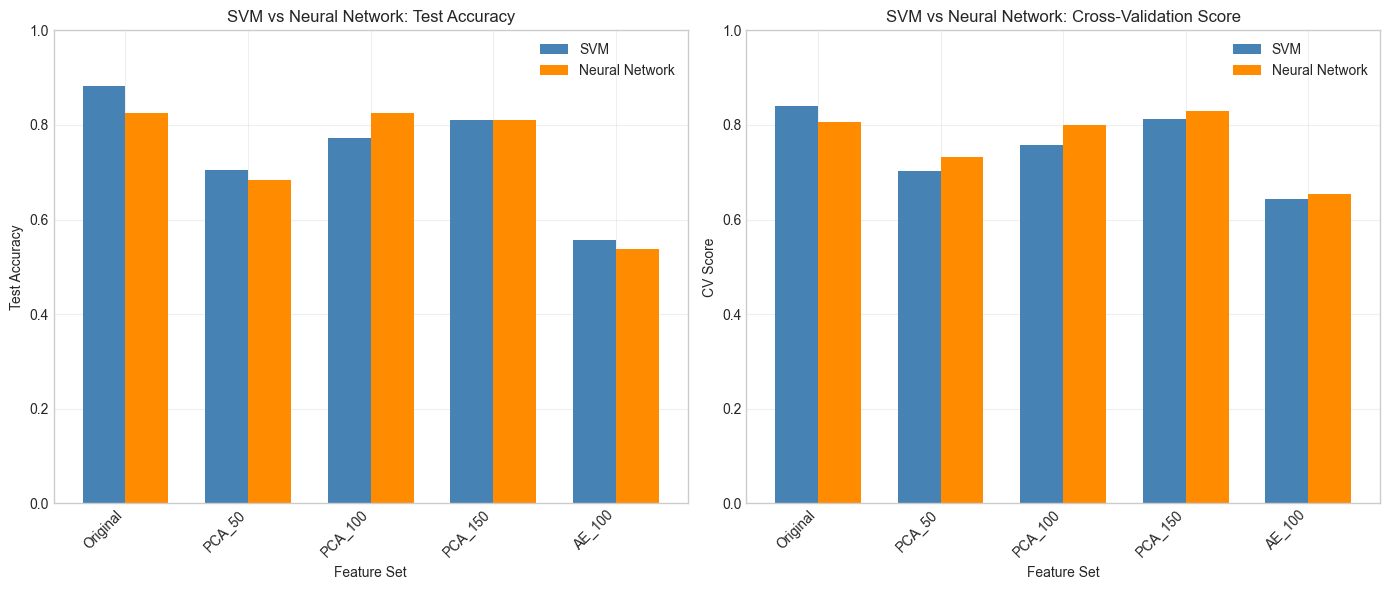

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

svm_data = comparison_df[comparison_df['Classifier'] == 'SVM']
nn_data = comparison_df[comparison_df['Classifier'] == 'NN']
x = np.arange(len(svm_data))
width = 0.35

axes[0].bar(x - width/2, svm_data['Test_Accuracy'], width, label='SVM', color='steelblue')
axes[0].bar(x + width/2, nn_data['Test_Accuracy'].values, width, label='Neural Network', color='darkorange')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('SVM vs Neural Network: Test Accuracy')
axes[0].set_xticks(x)
axes[0].set_xticklabels(svm_data['Features'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3)

axes[1].bar(x - width/2, svm_data['CV_Score'], width, label='SVM', color='steelblue')
axes[1].bar(x + width/2, nn_data['CV_Score'].values, width, label='Neural Network', color='darkorange')
axes[1].set_xlabel('Feature Set')
axes[1].set_ylabel('CV Score')
axes[1].set_title('SVM vs Neural Network: Cross-Validation Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(svm_data['Features'], rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classifier_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [34]:
print("\nCONFRONTO RIDUZIONE DIMENSIONALE: PCA vs AUTOENCODER")

dim_reduction_comparison = {
    'Metodo': ['Nessuna', 'PCA (50)', 'PCA (100)', 'PCA (150)', f'Autoencoder ({encoding_dim})'],
    'Dimensioni': [n_features, 50, 100, 150, encoding_dim],
    'SVM Accuracy': [results['SVM_Original']['metrics']['accuracy'], results['SVM_PCA_50']['metrics']['accuracy'], results['SVM_PCA_100']['metrics']['accuracy'], results['SVM_PCA_150']['metrics']['accuracy'], results[f'SVM_AE_{encoding_dim}']['metrics']['accuracy']],
    'NN Accuracy': [results['NN_Original']['metrics']['accuracy'], results['NN_PCA_50']['metrics']['accuracy'], results['NN_PCA_100']['metrics']['accuracy'], results['NN_PCA_150']['metrics']['accuracy'], results[f'NN_AE_{encoding_dim}']['metrics']['accuracy']]
}

dim_reduction_df = pd.DataFrame(dim_reduction_comparison)
dim_reduction_df['Riduzione (%)'] = (1 - dim_reduction_df['Dimensioni'] / n_features) * 100
print(dim_reduction_df.to_string(index=False, float_format='%.4f'))


CONFRONTO RIDUZIONE DIMENSIONALE: PCA vs AUTOENCODER
           Metodo  Dimensioni  SVM Accuracy  NN Accuracy  Riduzione (%)
          Nessuna        1850        0.8820       0.8261         0.0000
         PCA (50)          50        0.7050       0.6832        97.2973
        PCA (100)         100        0.7733       0.8261        94.5946
        PCA (150)         150        0.8106       0.8106        91.8919
Autoencoder (100)         100        0.5559       0.5373        94.5946


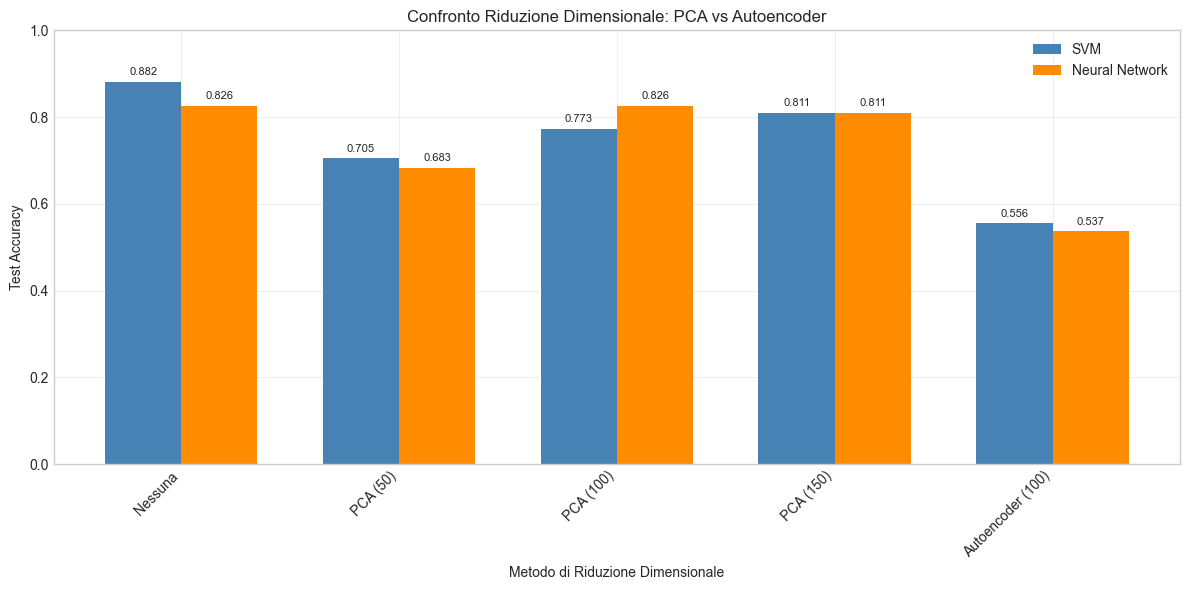

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(dim_reduction_df))
width = 0.35

bars1 = ax.bar(x - width/2, dim_reduction_df['SVM Accuracy'], width, label='SVM', color='steelblue')
bars2 = ax.bar(x + width/2, dim_reduction_df['NN Accuracy'], width, label='Neural Network', color='darkorange')

ax.set_xlabel('Metodo di Riduzione Dimensionale')
ax.set_ylabel('Test Accuracy')
ax.set_title('Confronto Riduzione Dimensionale: PCA vs Autoencoder')
ax.set_xticks(x)
ax.set_xticklabels(dim_reduction_df['Metodo'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

for bar, val in zip(bars1, dim_reduction_df['SVM Accuracy']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars2, dim_reduction_df['NN Accuracy']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('dim_reduction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Visualizzazioni Aggiuntive

In [36]:
print("Generazione visualizzazione t-SNE...")

n_samples_tsne = min(500, len(X_test_scaled))
indices_tsne = np.random.choice(len(X_test_scaled), n_samples_tsne, replace=False)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

X_tsne_original = tsne.fit_transform(X_test_scaled[indices_tsne])
X_tsne_pca = tsne.fit_transform(X_test_pca[100][indices_tsne])
X_tsne_ae = tsne.fit_transform(X_test_ae[indices_tsne])
y_tsne = y_test[indices_tsne]

Generazione visualizzazione t-SNE...


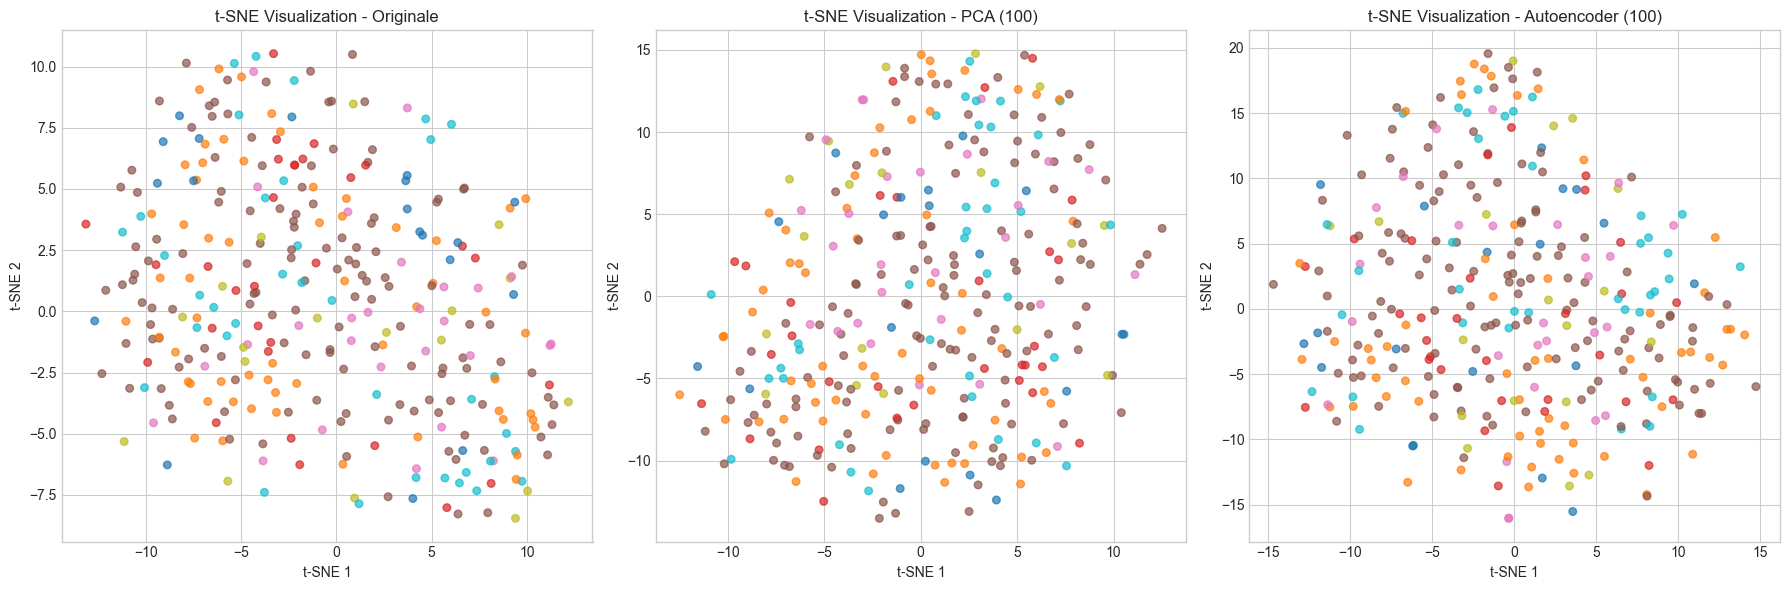

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, data, title in zip(axes, [X_tsne_original, X_tsne_pca, X_tsne_ae], ['Originale', 'PCA (100)', f'Autoencoder ({encoding_dim})']):
    scatter = ax.scatter(data[:, 0], data[:, 1], c=y_tsne, cmap='tab10', alpha=0.7, s=30)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title(f't-SNE Visualization - {title}')

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

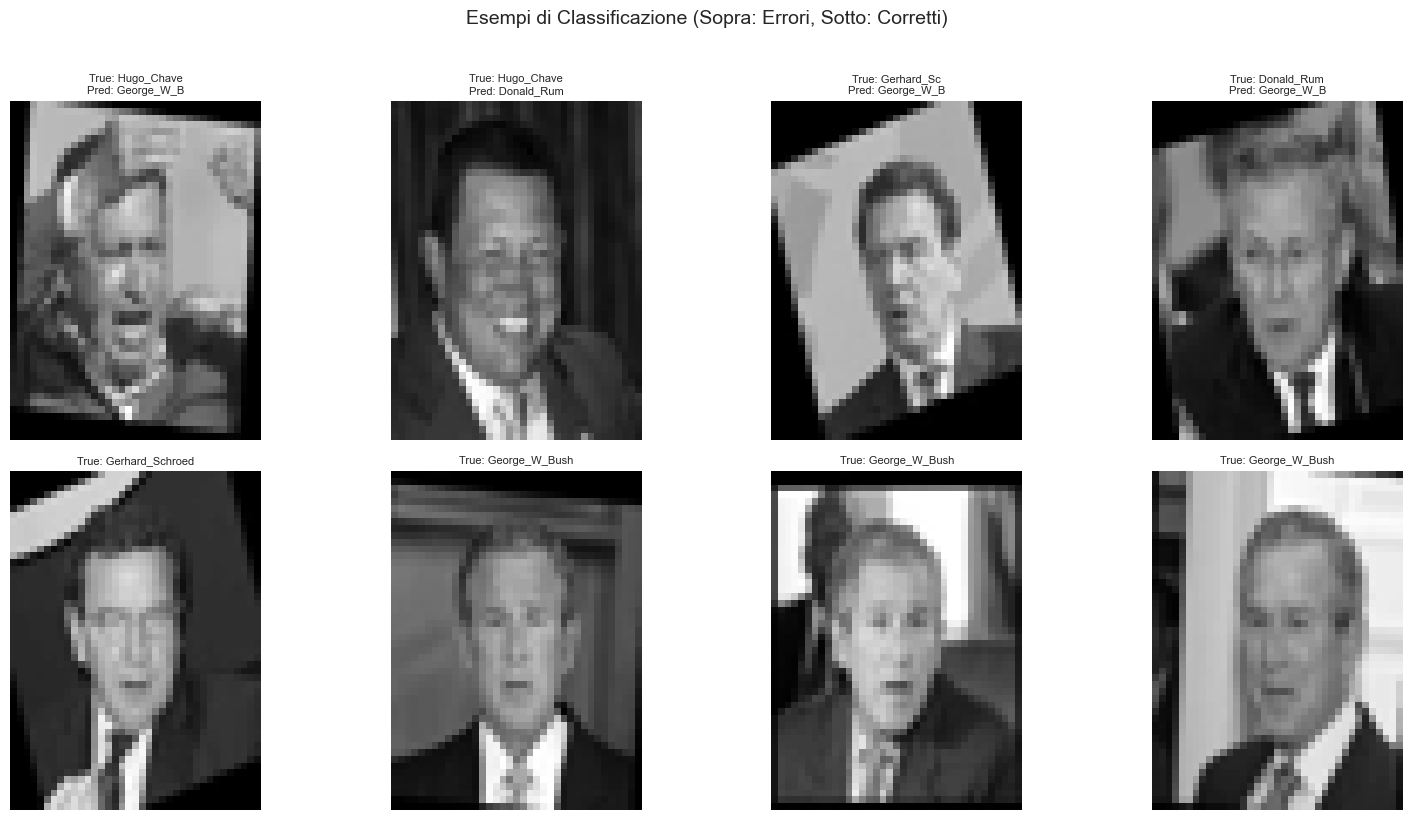

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

misclassified_idx = np.where(best_model_metrics['y_pred'] != y_test)[0]
if len(misclassified_idx) > 0:
    sample_misclassified = misclassified_idx[:min(4, len(misclassified_idx))]
    for i, idx in enumerate(sample_misclassified):
        img = scaler.inverse_transform(X_test_scaled[idx].reshape(1, -1)).reshape(h, w)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'True: {target_names[y_test[idx]][:10]}\nPred: {target_names[best_model_metrics["y_pred"][idx]][:10]}', fontsize=8)
        axes[0, i].axis('off')

correct_idx = np.where(best_model_metrics['y_pred'] == y_test)[0]
sample_correct = np.random.choice(correct_idx, min(4, len(correct_idx)), replace=False)
for i, idx in enumerate(sample_correct):
    img = scaler.inverse_transform(X_test_scaled[idx].reshape(1, -1)).reshape(h, w)
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'True: {target_names[y_test[idx]][:15]}', fontsize=8)
    axes[1, i].axis('off')

plt.suptitle('Esempi di Classificazione (Sopra: Errori, Sotto: Corretti)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('classification_examples.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Salvataggio Modelli

In [40]:
os.makedirs('models', exist_ok=True)

joblib.dump(scaler, 'models/scaler.joblib')
print("Salvato: scaler.joblib")

for n_comp in pca_components_list:
    joblib.dump(pca_models[n_comp], f'models/pca_{n_comp}.joblib')
    print(f"Salvato: pca_{n_comp}.joblib")

ae_data = {
    'encoding_dims': encoding_dims,
    'input_dim': n_features,
    'n_layers': len(autoencoder.weights)
}
for i, (w, b) in enumerate(zip(autoencoder.weights, autoencoder.biases)):
    ae_data[f'weight_{i}'] = w
    ae_data[f'bias_{i}'] = b
np.savez('models/autoencoder_weights.npz', **ae_data)
print("Salvato: autoencoder_weights.npz")

for name, data in results.items():
    joblib.dump(data['model'], f'models/{name.lower()}_model.joblib')
    print(f"Salvato: {name.lower()}_model.joblib")

print("\nTutti i modelli sono stati salvati nella cartella 'models/'")

Salvato: scaler.joblib
Salvato: pca_50.joblib
Salvato: pca_100.joblib
Salvato: pca_150.joblib
Salvato: autoencoder_weights.npz
Salvato: svm_original_model.joblib
Salvato: nn_original_model.joblib
Salvato: svm_pca_50_model.joblib
Salvato: nn_pca_50_model.joblib
Salvato: svm_pca_100_model.joblib
Salvato: nn_pca_100_model.joblib
Salvato: svm_pca_150_model.joblib
Salvato: nn_pca_150_model.joblib
Salvato: svm_ae_100_model.joblib
Salvato: nn_ae_100_model.joblib

Tutti i modelli sono stati salvati nella cartella 'models/'


## 13. Predizioni su Immagini Nuove

In [41]:
def predict_face(image, model_name='SVM_PCA_100'):
    image_flat = image.flatten().reshape(1, -1) if image.ndim == 2 else image.reshape(1, -1)
    image_scaled = scaler.transform(image_flat)
    
    if 'PCA' in model_name:
        n_comp = int(model_name.split('_')[-1])
        image_transformed = pca_models[n_comp].transform(image_scaled)
    elif 'AE' in model_name:
        image_transformed = autoencoder.encode(image_scaled)
    else:
        image_transformed = image_scaled
    
    model = results[model_name]['model']
    prediction = model.predict(image_transformed)
    
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(image_transformed)[0]
    elif hasattr(model, 'decision_function'):
        decision = model.decision_function(image_transformed)[0]
        proba = (decision - decision.min()) / (decision.max() - decision.min())
    else:
        proba = None
    
    return prediction[0], target_names[prediction[0]], proba

def verify_faces(image1, image2, method='PCA', metric='cosine', threshold=None):
    img1 = image1.flatten() if image1.ndim == 2 else image1
    img2 = image2.flatten() if image2.ndim == 2 else image2
    
    img1_scaled = scaler.transform(img1.reshape(1, -1))
    img2_scaled = scaler.transform(img2.reshape(1, -1))
    
    if method == 'PCA':
        feat1 = pca_models[100].transform(img1_scaled)[0]
        feat2 = pca_models[100].transform(img2_scaled)[0]
    elif method == 'AE':
        feat1 = autoencoder.encode(img1_scaled)[0]
        feat2 = autoencoder.encode(img2_scaled)[0]
    else:
        feat1, feat2 = img1_scaled[0], img2_scaled[0]
    
    if metric == 'cosine':
        similarity = cosine_similarity(feat1, feat2)
        threshold = threshold or 0.5
    else:
        similarity = -euclidean_distance(feat1, feat2)
        threshold = threshold or -50
    
    return similarity >= threshold, similarity

DIMOSTRAZIONE PREDIZIONI SU IMMAGINI NON VISTE


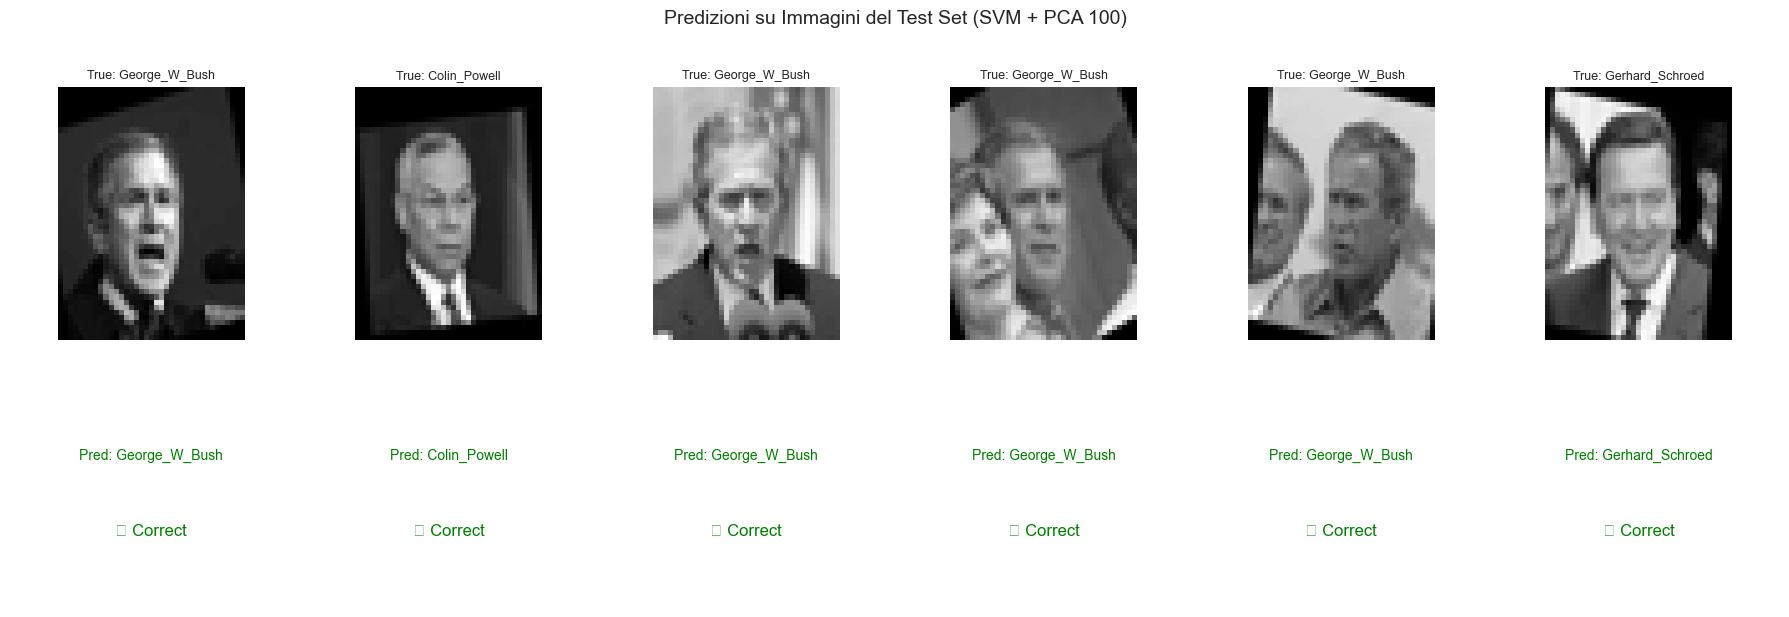

In [43]:
print("DIMOSTRAZIONE PREDIZIONI SU IMMAGINI NON VISTE")

n_demo = 6
demo_indices = np.random.choice(len(X_test), n_demo, replace=False)

img_h, img_w = images.shape[1], images.shape[2]

fig, axes = plt.subplots(2, n_demo, figsize=(18, 6))

for i, idx in enumerate(demo_indices):
    image = X_test[idx]
    true_label = y_test[idx]
    pred_class, pred_name, proba = predict_face(image, 'SVM_PCA_100')
    
    axes[0, i].imshow(image.reshape(img_h, img_w), cmap='gray')
    axes[0, i].set_title(f'True: {target_names[true_label][:15]}', fontsize=9)
    axes[0, i].axis('off')
    
    color = 'green' if pred_class == true_label else 'red'
    axes[1, i].text(0.5, 0.6, f'Pred: {pred_name[:15]}', ha='center', va='center', fontsize=10, color=color, transform=axes[1, i].transAxes)
    axes[1, i].text(0.5, 0.3, '✓ Correct' if pred_class == true_label else '✗ Wrong', ha='center', va='center', fontsize=12, color=color, transform=axes[1, i].transAxes)
    axes[1, i].axis('off')

plt.suptitle('Predizioni su Immagini del Test Set (SVM + PCA 100)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('prediction_demo.png', dpi=150, bbox_inches='tight')
plt.show()


DIMOSTRAZIONE VERIFICA FACCIALE


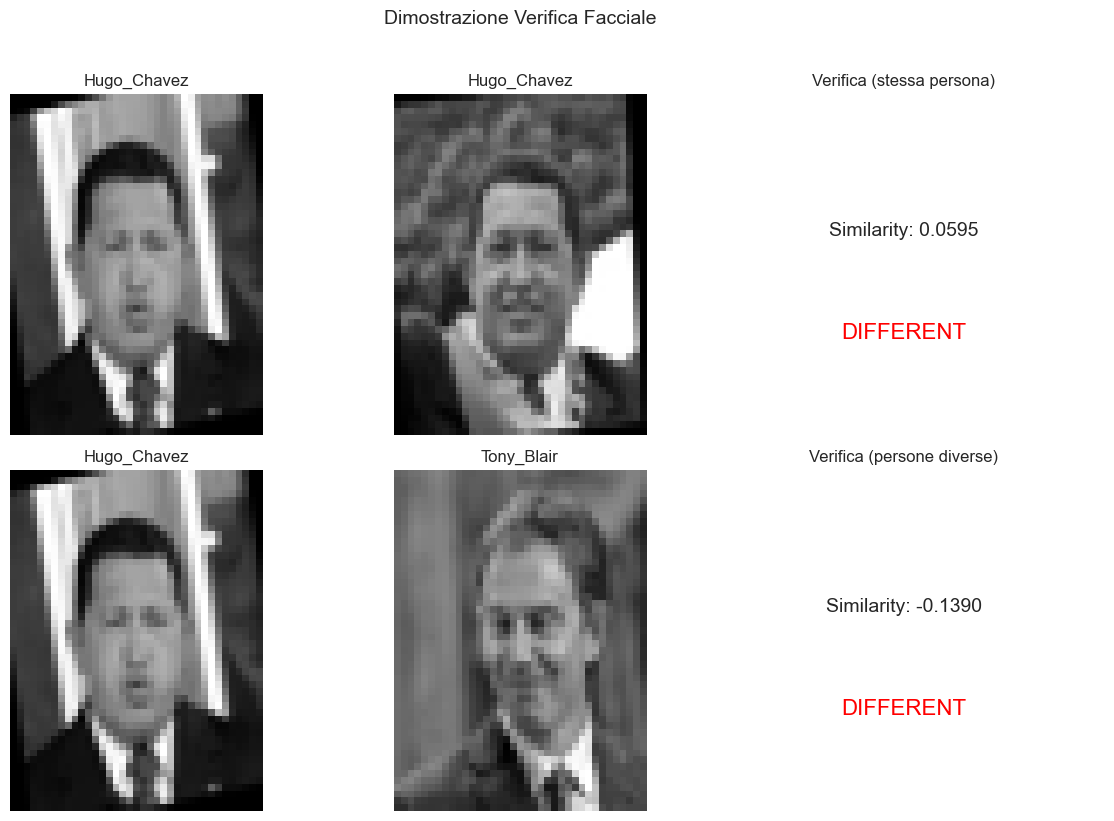

In [44]:
print("\nDIMOSTRAZIONE VERIFICA FACCIALE")

img_h, img_w = images.shape[1], images.shape[2]

same_person_class = np.random.choice(np.unique(y_test))
same_person_indices = np.where(y_test == same_person_class)[0]
idx1, idx2 = np.random.choice(same_person_indices, 2, replace=False) if len(same_person_indices) >= 2 else (same_person_indices[0], same_person_indices[0])

different_person_class = np.random.choice([c for c in np.unique(y_test) if c != same_person_class])
idx3 = np.random.choice(np.where(y_test == different_person_class)[0])

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(X_test[idx1].reshape(img_h, img_w), cmap='gray')
axes[0, 0].set_title(f'{target_names[y_test[idx1]][:15]}')
axes[0, 0].axis('off')

axes[0, 1].imshow(X_test[idx2].reshape(img_h, img_w), cmap='gray')
axes[0, 1].set_title(f'{target_names[y_test[idx2]][:15]}')
axes[0, 1].axis('off')

is_same, sim = verify_faces(X_test[idx1], X_test[idx2], method='PCA', metric='cosine')
axes[0, 2].text(0.5, 0.6, f'Similarity: {sim:.4f}', ha='center', va='center', fontsize=14, transform=axes[0, 2].transAxes)
axes[0, 2].text(0.5, 0.3, 'SAME PERSON' if is_same else 'DIFFERENT', ha='center', va='center', fontsize=16, color='green' if is_same else 'red', transform=axes[0, 2].transAxes)
axes[0, 2].set_title('Verifica (stessa persona)')
axes[0, 2].axis('off')

axes[1, 0].imshow(X_test[idx1].reshape(img_h, img_w), cmap='gray')
axes[1, 0].set_title(f'{target_names[y_test[idx1]][:15]}')
axes[1, 0].axis('off')

axes[1, 1].imshow(X_test[idx3].reshape(img_h, img_w), cmap='gray')
axes[1, 1].set_title(f'{target_names[y_test[idx3]][:15]}')
axes[1, 1].axis('off')

is_same, sim = verify_faces(X_test[idx1], X_test[idx3], method='PCA', metric='cosine')
axes[1, 2].text(0.5, 0.6, f'Similarity: {sim:.4f}', ha='center', va='center', fontsize=14, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.5, 0.3, 'SAME PERSON' if is_same else 'DIFFERENT', ha='center', va='center', fontsize=16, color='green' if is_same else 'red', transform=axes[1, 2].transAxes)
axes[1, 2].set_title('Verifica (persone diverse)')
axes[1, 2].axis('off')

plt.suptitle('Dimostrazione Verifica Facciale', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('verification_demo.png', dpi=150, bbox_inches='tight')
plt.show()

## 14. Riepilogo Finale

In [45]:
print("\n" + "="*80)
print("RIEPILOGO FINALE DEL PROGETTO")
print("="*80)

print(f"\n📊 DATASET")
print(f"   Dataset: LFW (Labeled Faces in the Wild)")
print(f"   Campioni: {n_samples}, Classi: {n_classes}, Features: {n_features}")

print(f"\n📉 RIDUZIONE DIMENSIONALE")
print(f"   PCA: testati {pca_components_list} componenti")
print(f"   Autoencoder: {encoding_dim} dimensioni latenti")

print(f"\n🎯 MIGLIORI RISULTATI CLASSIFICAZIONE")
best_acc = metrics_df['Accuracy'].max()
best_model = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Modello']
print(f"   Miglior modello: {best_model}")
print(f"   Accuracy: {best_acc:.4f}")

print(f"\n🔐 VERIFICA FACCIALE")
best_verif = max(verification_results.items(), key=lambda x: x[1]['auc'])
print(f"   Miglior configurazione: {best_verif[0]}")
print(f"   AUC: {best_verif[1]['auc']:.4f}")

print(f"\n📁 FILE GENERATI")
print("   - classification_metrics.csv")
print("   - verification_metrics.csv")
print("   - models/*.joblib (modelli salvati)")
print("   - *.png (grafici e visualizzazioni)")

print("\n" + "="*80)
print("PROGETTO COMPLETATO CON SUCCESSO!")
print("="*80)


RIEPILOGO FINALE DEL PROGETTO

📊 DATASET
   Dataset: LFW (Labeled Faces in the Wild)
   Campioni: 1288, Classi: 7, Features: 1850

📉 RIDUZIONE DIMENSIONALE
   PCA: testati [50, 100, 150] componenti
   Autoencoder: 100 dimensioni latenti

🎯 MIGLIORI RISULTATI CLASSIFICAZIONE
   Miglior modello: SVM_Original
   Accuracy: 0.8820

🔐 VERIFICA FACCIALE
   Miglior configurazione: PCA_100_cosine
   AUC: 0.5976

📁 FILE GENERATI
   - classification_metrics.csv
   - verification_metrics.csv
   - models/*.joblib (modelli salvati)
   - *.png (grafici e visualizzazioni)

PROGETTO COMPLETATO CON SUCCESSO!
